In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths
from utils import prf_utils


In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf_fit_pRFs'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False, return_filename=False) \
       for ss in subjects]

In [3]:
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

In [4]:
# pull out the pRF params

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg


In [5]:
# non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [6]:
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff


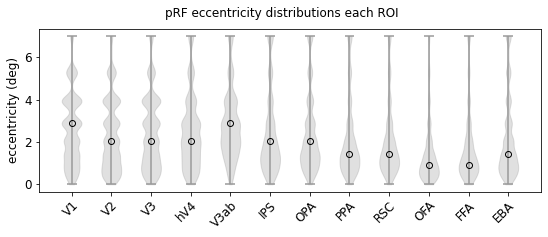

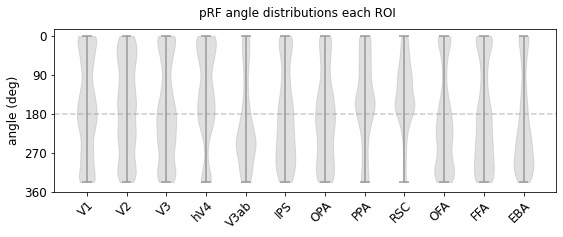

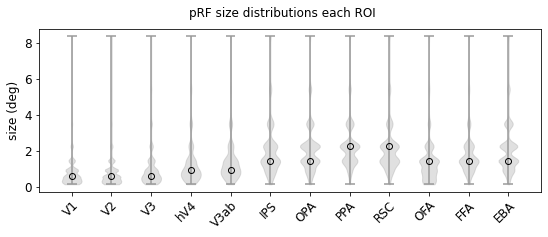

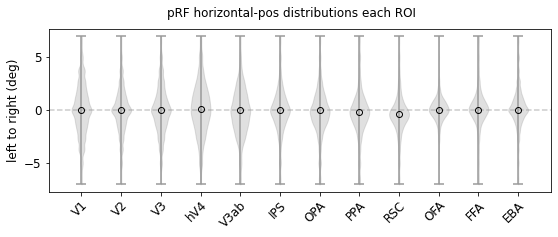

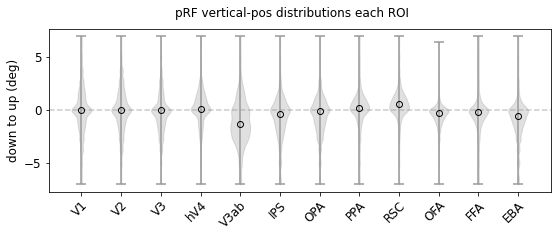

In [7]:
# make violin plots for each parameter
import copy

plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

parslist = [eccen_fwrf, angle_fwrf, size_fwrf, x*screen_eccen_deg, y*screen_eccen_deg]
parnames = ['eccentricity', 'angle', 'size', 'horizontal-pos', 'vertical-pos']
axnames = ['eccentricity (deg)', 'angle (deg)', 'size (deg)', 'left to right (deg)', 'down to up (deg)']

color = [0.6, 0.6, 0.6]

for pp, pars in enumerate(parslist):
   
    pi=0
    # plt.figure(figsize=(12,3))
    plt.figure(figsize=(9,3))

    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh
        vals = copy.deepcopy(pars[inds_this_roi])
         
        parts = plt.violinplot(vals,[rr])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)


        if parnames[pp]!='angle':
            plt.plot(rr, np.median(vals), 'o',\
                     markeredgecolor='k',markerfacecolor='none')

    if parnames[pp]=='angle':
        plt.yticks([0,90,180,270,360])
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.ylabel(axnames[pp])

    if 'pos' in parnames[pp]:
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if pp==1:
        plt.gca().invert_yaxis()
            
    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')
           
    plt.suptitle('pRF %s distributions each ROI'%parnames[pp])

    fn2save = os.path.join(default_paths.fig_path,'prf_%s_violins.pdf'%parnames[pp])
    plt.savefig(fn2save)

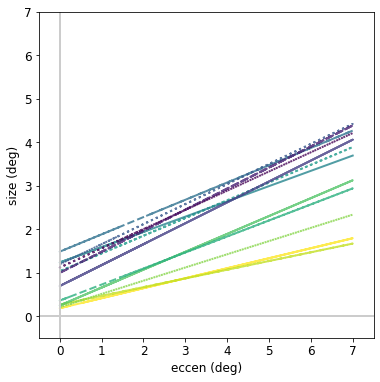

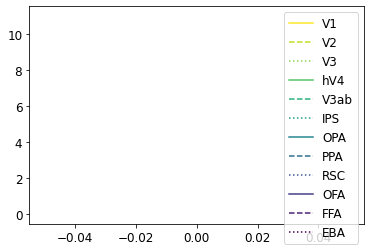

In [8]:
plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(12)
size_lims = [-0.5,7.0]
eccen_lims = [-0.5,7.5]

plt.figure(figsize=(6,6))

roi_colors = np.flipud(cm.viridis(np.linspace(0,1,n_rois))[0:n_rois])
linestyles = np.tile(['-','--',':'], int(n_rois/3))
lh = []

for rr in range(n_rois):

    inds2use = np.where(roi_def.get_indices(rr) & abv_thresh)[0]
  
    xvals = eccen_fwrf[inds2use]
    yvals = size_fwrf[inds2use]
    
    # quick linear regression to get a best fit line
    X = np.concatenate([xvals[:,np.newaxis], np.ones((len(inds2use),1))], axis=1)
    y = yvals[:,np.newaxis]
    linefit =  np.linalg.pinv(X) @ y

    yhat = xvals*linefit[0] + linefit[1]
    
    plt.plot(xvals, yhat, linestyles[rr], color=roi_colors[rr], linewidth=2, alpha=0.8)
    
    plt.xlim(eccen_lims)
    plt.ylim(size_lims)

    plt.xlabel('eccen (deg)')
    plt.ylabel('size (deg)')
    
    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.axvline(0,color=[0.8, 0.8, 0.8])
    

# fn2save = os.path.join(default_paths.fig_path,'Size_eccen_bestfits.pdf')
# plt.savefig(fn2save)

plt.figure();
for rr in range(n_rois):
    plt.plot(0,rr,linestyles[rr],color=roi_colors[rr])
plt.legend(roi_names)

# fn2save = os.path.join(default_paths.fig_path,'Size_eccen_bestfits_legend.pdf')
# plt.savefig(fn2save)


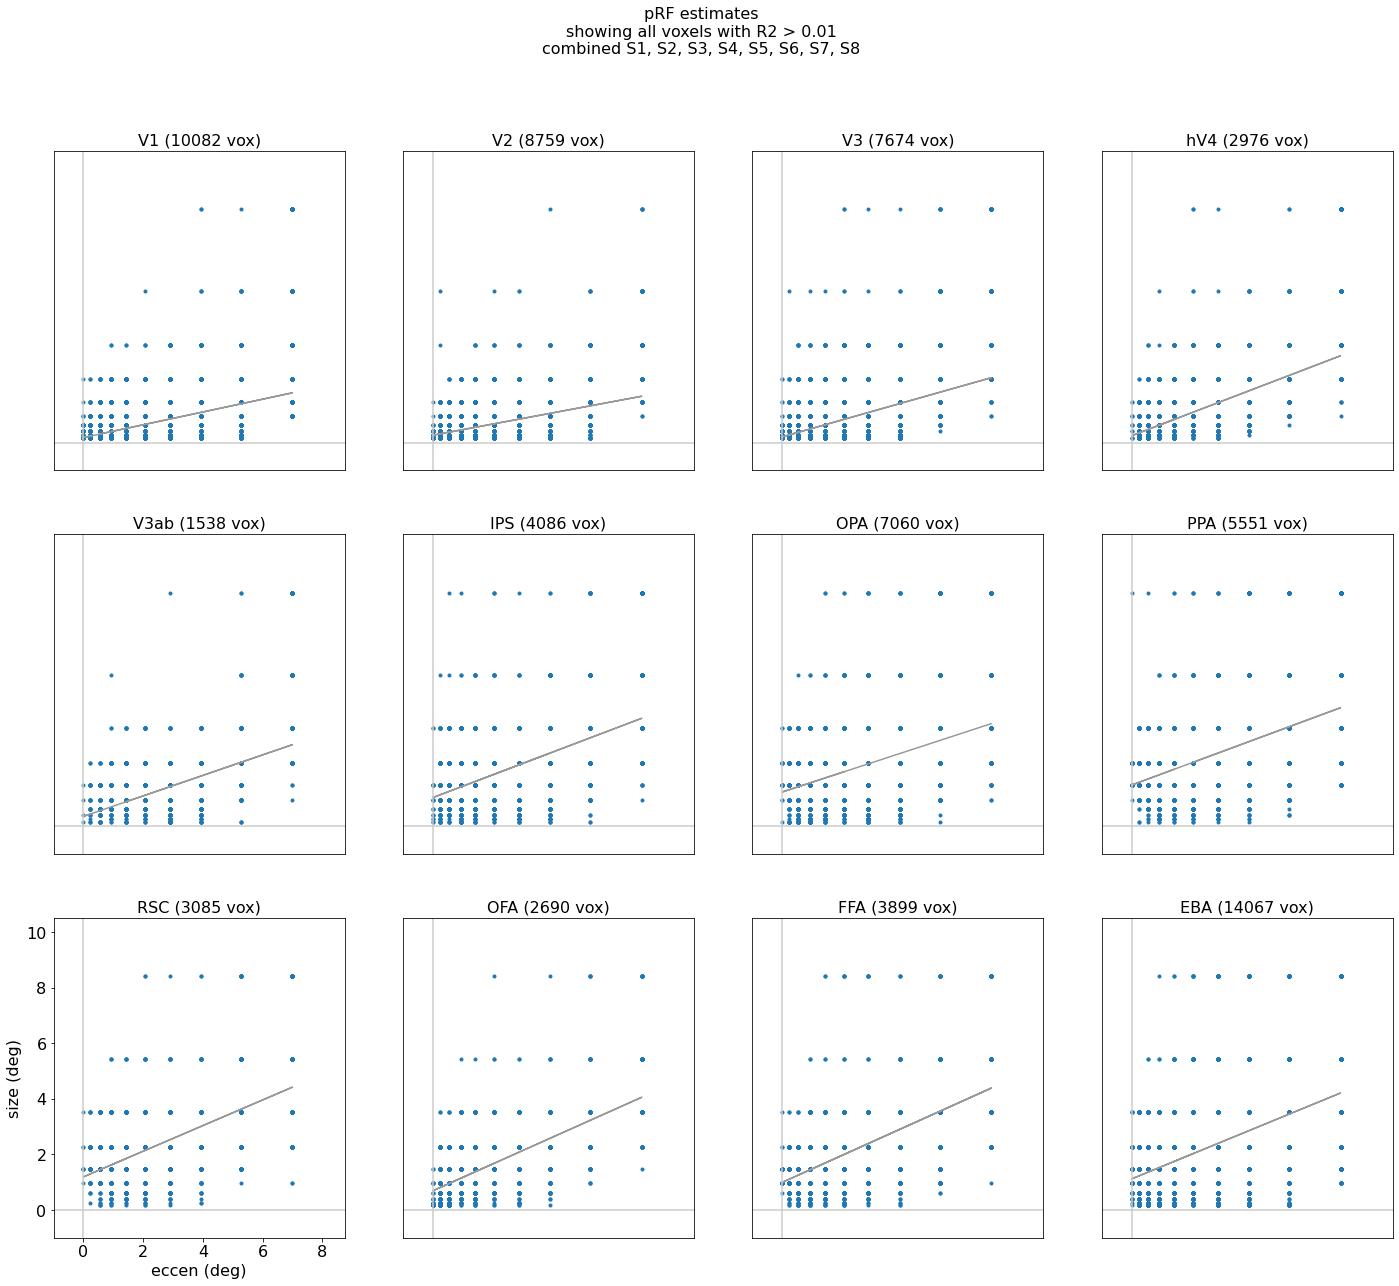

In [9]:
# single voxel size/eccen
plot_utils.set_all_font_sizes(fs = 16)
plot_prf_params.plot_size_vs_eccen('', out, roi_def=roi_def,\
                                   r2_cutoff=0.01, fig_save_folder=None)